# Studentized Residuals

Reference
- Wiki : https://en.wikipedia.org/wiki/Studentized_residual
- Penn : https://online.stat.psu.edu/stat462/node/247/

## 1. 개요

제가 여러방면으로 찾아봤을 때 External Studentized Residual를 공부하는데 가장 좋은 자료는 Wiki입니다. 다만 검증 대상이 필요하고 더욱 진보된 알고리즘이 필요한데 Penn 대학의 자료를 참조하면 됩니다.

기본적으로 Studentized Residual은 Internal과 External로 나누어져 있으며 둘 다 기본적인 Residual을 사용하여 새로운 Residual을 만드는데 사용합니다. 단, Internal은 한꺼번에 모든 데이터를 사용하여 Residual을 만들고 External은 한개씩 뺀 나머지 데이터를 사용하여 Residual을 만듭니다.

## 2. Deleted Residuals

개요에서 언급한 한개씩 빼서 계산하는 방식이 Deleted Residuals 방식입니다. 이는 다음과 같은 절차로 계산합니다.

1. 한개의 데이터를 빼고 Regression을 진행합니다.
2. 그에 따른 Residual을 구합니다.
3. 수식 : $d_i=y_i-\hat{y}_{(i)}$ (i번째 값을 제외하고 계산한 Residual)

글로 작성하면 매우 추상적이니 Penn에서 제공한 예제를 작성하겠습니다.

아래의 데이터가 있을 때 가장 아래 있는 (10, 2.1)을 대상으로 수식을 작성해보겠습니다.

|   X   |   Y   |
| :---: | :---: |
|   1   |  2.1  |
|   2   |  3.8  |
|   3   |  5.2  |
|  10   |  2.1  |

(10, 2.1)을 제외하고 회귀분석을 하면 다음과 같은 수식을 얻을 수 있습니다.

$$y=0.6+1.55x$$

이 수식에 사용하지 않았던 10을 넣으면 16.1이 되고 원래 값인 2.1을 빼면 -14가 됩니다. 이런 계산법이 Deleted Residuals 입니다. 이런 수식을 사용하면 Outlier 처리에 매우 용이합니다.

이를 코드로 전환하면 아래와 같이 작성할 수 있습니다.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.family"] = "gulim"
pd.set_option('display.precision', 2)

X = np.array([1.0, 2.0, 3.0, 10.0]).reshape(-1,1)
X = np.insert(X, 0, 1, 1) # 앞에 상수항을 만들어주기 위해 1을 추가
y = np.array([2.1, 3.8, 5.2, 2.1]).reshape(-1,1)

In [12]:
# 일반적으로 Residual 구하는 경우

coef, *_ = np.linalg.lstsq(X, y, rcond=-1)
resid = y - X @ coef

pd.DataFrame(np.hstack([X[..., 1:], y, resid]), columns=["X", "Y", "RESID"])

,X,Y,RESID
0,1.0,2.1,-1.59
1,2.0,3.8,0.24
2,3.0,5.2,1.77
3,10.0,2.1,-0.42


In [13]:
# Deleted Residual 구하는 경우

indices = np.array([0, 1, 1, 1], dtype=np.bool8)

d_resid = np.empty_like(y)

for _ in range(np.size(X, 0)):
    _coef, *_ = np.linalg.lstsq(X[indices], y[indices], rcond=-1)
    d_resid[~indices] = y[~indices] - X[~indices] @ _coef
    indices = np.roll(indices, 1)

pd.DataFrame(
    np.hstack([X[..., 1:], y, resid, d_resid]), 
    columns=["X", "Y", "RESID", "D RESID"]
)

,X,Y,RESID,D RESID
0,1.0,2.1,-1.59,-2.79
1,2.0,3.8,0.24,0.36
2,3.0,5.2,1.77,2.42
3,10.0,2.1,-0.42,-14.00


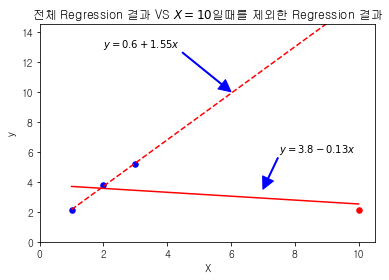

In [14]:
#  Normal Residuals VS (Unstandardized) Deleted Residuals

plt.figure()

plt.scatter(X[:3, 1], y[:3], color="b", s=30)
plt.scatter(X[3, 1], y[3], color="r", s=30)

arrowprops=dict(fc="blue", ec="blue", width=1)

plt.plot(X[:, 1], X @ coef, "r" )
intercept, __coef = coef.flatten()
plt.annotate(
    f"$y={intercept:.1f} - {np.abs(__coef):.2f}x$", 
    xy=(7, 3.5), 
    xytext=(7.5, 6), 
    arrowprops=arrowprops
)

plt.plot(X[:, 1], X @ _coef, "r--" )
intercept, __coef = _coef.flatten()
plt.annotate(
    f"$y={intercept:.1f} + {__coef:.2f}x$", 
    xy=(6, 10), 
    xytext=(2, 13), 
    arrowprops=arrowprops
)

plt.xlabel("X")
plt.ylabel("y")
plt.xlim(0, 10.5)
plt.ylim(0, 14.5)
plt.title("전체 Regression 결과 VS $X=10$일때를 제외한 Regression 결과")
plt.show()

## 3. (Internal) Studentized Residuals

Studentized Residuals은 Residual에 Residuals에 산포를 나누어서 계산합니다. Wiki에 작성되어있는 것 그대로 하면 되는데 그전에 앞서서 몇가지를 알면 좋습니다.

### 3.1 Hat Matrix

최소제곱법 계산법은 다음과 같습니다.

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

여기서 Prediction $\hat{y}$값을 구하기 위해서 $X$를 행렬연산에 넣으면 다음과 같습니다.

$$
\hat{y} = X(X^TX)^{-1}X^Ty
$$

Studentized Residuals에서 말하는 Hat Matrix란 위 $\hat{y}$를 구하기 위한 수식에서 $X$로만 구성되어있는 수식입니다.

$$H=X(X^TX)^{-1}X^T$$

즉, Hat Matrix $H$ 는 $\hat{y}$를 구하기 위한 투영행렬입니다.

### 3.2 Calculation

Studentized Residuals를 구하는 정의는 다음과 같습니다.

$$
t_i = \cfrac{\hat{\epsilon_i}}{\hat{\sigma}\sqrt{1-h_{ii}}}
$$

$h_{ii}$는 Hat Matrix의 대각행렬입니다. 또한 여기서 언급하는 $\hat{\sigma}$는 Residual의 표준편차로 계산 방법은 다음과 같습니다.

$$
\hat{\sigma}^2=\cfrac{1}{n-m}\sum_{j=1}^n \hat{\epsilon}_j^2
$$

$n$은 데이터 수이며, $m$은 파라미터 수입니다. $n$은 데이터 수가 총 4개이므로 4이며, $m$는 $X$값과 상수를 구하기 위한 1을 포함하여 2가 됩니다. 위 수식들을 실제 코드로 구현하면 다음과 같습니다.

In [15]:
import numpy as np
import pandas as pd

plt.rcParams["font.family"] = "gulim"
pd.set_option('display.precision', 2)

# 데이터 정의
X = np.array([1.0, 2.0, 3.0, 10.0]).reshape(-1,1)
X = np.insert(X, 0, 1, 1) # 앞에 상수항을 만들어주기 위해 1을 추가
y = np.array([2.1, 3.8, 5.2, 2.1]).reshape(-1,1)

n, m = X.shape  # n, m 구하기

# Hat Matrix 및 Hat Matrix Diagonal(대각행렬) 정의
H = X @ np.linalg.inv(X.T @ X) @ X.T
h = np.diag(H)

# Regression 후 Residual을 구합니다.
coef, *_ = np.linalg.lstsq(X, y, rcond=-1)
resid = (y - X @ coef).squeeze()

# Sigma 구하기 위한 변수 구하기
sigma = np.sqrt(1 / (n-m) * np.sum(resid**2))

# Studentized Residuals 구하기
it_resid = resid / (sigma * np.sqrt(1 - h))

# Display
columns = "X Y RESID IT-RESID".split()
pd.DataFrame(np.vstack([X[:,1], y[:,0], resid, it_resid]).T, columns=columns)


,X,Y,RESID,IT-RESID
0,1.0,2.1,-1.59,-1.23
1,2.0,3.8,0.24,0.17
2,3.0,5.2,1.77,1.21
3,10.0,2.1,-0.42,-1.41


## 4. External Studentized Residuals

(Internal) Studentized Residuals를 보면 알 수 있듯, Outlier 처리가 정상적으로 되지 않는 다는 것을 알 수 있습니다. 그래서 이런 경우에는 External Studentized Residuals를 적용해야합니다.

Studentized Residuals은 Deleted Residuals에 Residual에 산포를 나누어서 계산합니다. 당연하게도 한개씩 빼면서 계산해야하므로 $\hat{\sigma}$ 구하는 공식이 다소 달라집니다. 

$$
\hat{\sigma}_{(i)}^2=\cfrac{1}{n-m-1}\sum_{j=1,\; j\neq i}^n \hat{\epsilon}_j^2
$$

이 수식을 실제 구현할때 조심해야할 부분은 한 Residual 세트마다 한게의 Sigma $\hat{\sigma}_{(i)}$가 나온다는 것입니다.

In [16]:
import numpy as np
import pandas as pd

plt.rcParams["font.family"] = "gulim"
pd.set_option('display.precision', 2)

# 데이터 정의
X = np.array([1.0, 2.0, 3.0, 10.0]).reshape(-1,1)
X = np.insert(X, 0, 1, 1) # 앞에 상수항을 만들어주기 위해 1을 추가
y = np.array([2.1, 3.8, 5.2, 2.1]).reshape(-1,1)

n, m = X.shape  # n과 m 구하기

# Hat Matrix 및 Hat Matrix Diagonal(대각행렬) 정의
H = X @ np.linalg.inv(X.T @ X) @ X.T
h = np.diag(H)

# Regression 후 Residual을 구합니다.
coef, *_ = np.linalg.lstsq(X, y, rcond=-1)
resid = (y - X @ coef).squeeze()

# Sigma 구하기 위한 변수 구하기
indices = ~np.eye(n, dtype=np.bool8)    # 1개씩 빼면서 다른걸 선택하기 위한 방법
sigma = np.empty(n)

for i in range(n):    
    _coef, *_ = np.linalg.lstsq(X[indices[i]], y[indices[i]], rcond=-1)
    d_resid = y[indices[i]] - X[indices[i]] @ _coef
    sigma[i] = np.sqrt(1 / (n-m-1) * np.sum(d_resid**2))

# External Studentized Residuals 구하기
et_resid = resid / (sigma * np.sqrt(1 - h))

# Display
columns = "X Y RESID ET-RESID".split()
pd.DataFrame(np.vstack([X[:,1], y[:,0], resid, et_resid]).T, columns=columns)

,X,Y,RESID,ET-RESID
0,1.0,2.1,-1.59,-1.74
1,2.0,3.8,0.24,0.12
2,3.0,5.2,1.77,1.64
3,10.0,2.1,-0.42,-19.80


## 5. External Studentized Residuals 심화

이론적인 알고리즘을 구현하면 데이터가 많을수록 상당히 많은 연산을 해야합니다. 이를 개선하기 위한 수식이 있고 Penn 대학교 자료에서 확인할 수 있습니다.

$$
t_i=r_i \left (  \cfrac{n-m-1}{n-m-r_i^2}   \right )^{1/2}
$$

여기서 $r_i$는 Studentized Residuals의 값이며 $n$은 관측 갯수, $m$는 파라미터 갯수 입니다. 위에서 구현한 Studentized Residuals를 동일하게 가져와서 마지막 수식만 추가로 작성해보겠습니다.

단, Penn 대학교 자료와 다른점은 2가지가 있습니다.

1. Wiki와 동일하게 맞추기 위해 $k$ 변수를 $m$ 변수로 치환
2. 상수항을 제외하고 파라미터 갯수를 세기 때문에 Wiki와 맞추기 위해 -1 을 제거하였습니다.

In [17]:
import numpy as np
import pandas as pd

plt.rcParams["font.family"] = "gulim"
pd.set_option('display.precision', 2)

# 데이터 정의
X = np.array([1.0, 2.0, 3.0, 10.0]).reshape(-1,1)
X = np.insert(X, 0, 1, 1) # 앞에 상수항을 만들어주기 위해 1을 추가
y = np.array([2.1, 3.8, 5.2, 2.1]).reshape(-1,1)

n, m = X.shape  # n, m 구하기

# Hat Matrix 및 Hat Matrix Diagonal(대각행렬) 정의
H = X @ np.linalg.inv(X.T @ X) @ X.T
h = np.diag(H)

# Regression 후 Residual을 구합니다.
coef, *_ = np.linalg.lstsq(X, y, rcond=-1)
resid = (y - X @ coef).squeeze()

# Sigma 구하기 위한 변수 구하기
sigma = np.sqrt(1 / (n-m) * np.sum(resid**2))

# Studentized Residuals 구하기
it_resid = resid / (sigma * np.sqrt(1 - h))

# External Studentized Residuals 구하기
et_resid = it_resid * np.sqrt((n-1-2) / (n-1-1-it_resid**2))

# Display
columns = "X Y RESID IT-RESID ET-RESID".split()
pd.DataFrame(np.vstack([X[:,1], y[:,0], resid, it_resid, et_resid]).T, columns=columns)

,X,Y,RESID,IT-RESID,ET-RESID
0,1.0,2.1,-1.59,-1.23,-1.74
1,2.0,3.8,0.24,0.17,0.12
2,3.0,5.2,1.77,1.21,1.64
3,10.0,2.1,-0.42,-1.41,-19.80


## 6. External Studentized Residuals 개선

External Studentized Residuals 계산할 때 비싼 연산이 2가지가 있습니다.

1. Hat Matrix
2. Inverse Matrix (Regression 진행시)

하지만 2가지 계산은 Project Matrix가 중복되므로 중복되는 수식을 따로 빼서 계산할 수 있습니다.

$$
\begin{aligned}
&P = (X^TX)^{-1}X^T\\
&H=X(X^TX)^{-1}X^T&=XP\\
&\hat{\beta} = (X^TX)^{-1}X^Ty&=Py\\
&\hat{y} = X(X^TX)^{-1}X^Ty&=XPy
\end{aligned}
$$

바로 위의 수식을 복사해서 개선하겠습니다. 코드 작성 측면에서도 비교적 정리가 잘된다는 것을 알 수 있습니다.

In [18]:
import numpy as np
import pandas as pd

pd.set_option('display.precision', 2)

# 데이터 정의
X = np.array([1.0, 2.0, 3.0, 10.0]).reshape(-1,1)
X = np.insert(X, 0, 1, 1) # 앞에 상수항을 만들어주기 위해 1을 추가
y = np.array([2.1, 3.8, 5.2, 2.1]).reshape(-1,1)

n, m = X.shape  # n, m 구하기

# Projection Matrix
P = np.linalg.inv(X.T @ X) @ X.T

# Hat Matrix 및 Hat Matrix Diagonal(대각행렬) 정의
h = np.diag(X @ P)

# Regression 후 Residual을 구합니다.
resid = (y - X @ P @ y).squeeze()

# Sigma 구하기 위한 변수 구하기
sigma = np.sqrt(1 / (n-m) * np.sum(resid**2))

# Studentized Residuals 구하기
it_resid = resid / (sigma * np.sqrt(1 - h))

# External Studentized Residuals 구하기
et_resid = it_resid * np.sqrt((n-1-2) / (n-1-1-it_resid**2))

# Display
columns = "X Y RESID IT-RESID ET-RESID".split()
pd.DataFrame(np.vstack([X[:,1], y[:,0], resid, it_resid, et_resid]).T, columns=columns)

,X,Y,RESID,IT-RESID,ET-RESID
0,1.0,2.1,-1.59,-1.23,-1.74
1,2.0,3.8,0.24,0.17,0.12
2,3.0,5.2,1.77,1.21,1.64
3,10.0,2.1,-0.42,-1.41,-19.80


## 7. External Studentized Residuals 쉽게 사용하기

Python에서 단순히 데이터만 확인하고자 할때는 `statsmodels`를 사용하여 쉽게 구할 수 있습니다. 다만, 성능이 다소 떨어지므로 다수의 데이터를 처리할 때는 위에 직접 구한 알고리즘을 사용하시는 것이 좋습니다. 약 50배 이상 차이가 납니다.

In [23]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# 데이터 정의
X = np.array([1.0, 2.0, 3.0, 10.0]).reshape(-1,1)
X = np.insert(X, 0, 1, 1) # 앞에 상수항을 만들어주기 위해 1을 추가
y = np.array([2.1, 3.8, 5.2, 2.1]).reshape(-1,1)

regr = sm.OLS(y, X)
result = regr.fit()

# Display
columns = "ET_RESID,Unadjusted p-value,Corrected p-value".split(",")
pd.DataFrame(result.outlier_test(),columns=columns)

,ET_RESID,Unadjusted p-value,Corrected p-value
0,-1.74,0.33,1.00
1,0.12,0.92,1.00
2,1.64,0.35,1.00
3,-19.80,0.03,0.13


## 8. 추가 사례



In [38]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

df = pd.read_csv("../data/influence2.csv")

X = df[["x"]].to_numpy()
X = np.insert(X, 0, 1, 1)
y = df[["y"]].to_numpy()

n, m = X.shape  # n, m 구하기

# Projection Matrix
P = np.linalg.inv(X.T @ X) @ X.T

# Hat Matrix 및 Hat Matrix Diagonal(대각행렬) 정의
h = np.diag(X @ P)

# Regression 후 Residual을 구합니다.
resid = (y - X @ P @ y).squeeze()

# Sigma 구하기 위한 변수 구하기
sigma = np.sqrt(1 / (n-m) * np.sum(resid**2))

# Studentized Residuals 구하기
it_resid = resid / (sigma * np.sqrt(1 - h))

# External Studentized Residuals 구하기
et_resid = it_resid * np.sqrt((n-1-2) / (n-1-1-it_resid**2))

# Display
columns = "X Y RESID IT-RESID ET-RESID".split()
pd.DataFrame(np.vstack([X[:,1], y[:,0], resid, it_resid, et_resid]).T, columns=columns)

,X,Y,RESID,IT-RESID,ET-RESID
0,0.10,-0.07,-3.53,-0.83,-0.82
1,0.45,4.17,-1.08,-0.25,-0.24
2,1.10,6.57,-1.92,-0.44,-0.43
3,1.28,13.81,4.41,1.00,1.00
4,2.21,11.45,-2.62,-0.58,-0.57
5,2.50,12.96,-2.60,-0.57,-0.56
6,3.04,20.16,1.88,0.41,0.40
7,3.24,17.56,-1.69,-0.37,-0.36
8,4.45,26.03,0.64,0.14,0.14
9,4.17,22.76,-1.21,-0.26,-0.26
